In [1]:
import numpy as np

inf = np.inf
isclose = np.isclose

class Controller(object):
    '''Single Axis PID Controller
    goals:
        self-tuning
        edge-case switching to PD or PI
    '''

    def __init__(self,set_point=0,kp=1,ki=0,kd=0,t0=0):
        # set point and control constants
        self.set_point = set_point
        self.kp = kp
        self.ki = ki
        self.kd = kd

        # time of previous call, running integral and
        # proportional term of previous call
        self.t0 = t0
        self.I  = 0
        self.P0 = 0

        # limits
        self.min = -inf
        self.max =  inf

        # response value of previous call
        self.c = 0

    def __call__(self,x,t):
        # return previous value if no time has passed
        if isclose(t - self.t0, 0):
            return self.c

        # bring instance variables into local scope
        xset = self.set_point
        kp = self.kp
        ki = self.ki
        kd = self.kd

        # if parameters are all zero or None, return set point
        if not any([kp,ki,kd]):
            self.t0 = t
            return xset

        # bring instance variables into local scope
        t0 = self.t0
        I  = self.I
        P0 = self.P0

        # calculate PID terms
        Δt = t - t0
        P = xset - x
        ΔP = P - P0
        D = ΔP / Δt

        # freeze integral for a small time on
        # a large disturbance
        if self.ki > 0:
            if abs(kp*ΔP) > 0.5*(self.max - self.min):
                self._t0_freeze_I = t
            else:
                try:
                    if (t - self._t0_freeze_I) > self.ti:
                        del self._t0_freeze_I
                        I += P * Δt
                except AttributeError:
                    I += P * Δt

            # turn off integral term if P*km is out of the
            # control range
            if not (self.min < kp*P < self.max):
                I = 0
            else:
                I = min(max(I, self.min/ki), self.max/ki)

        # clip proportional gain
        if not (self.min < kp*P < self.max):
            P = min(max(P, self.min/kp), self.max/kp)

        c = kp*P + ki*I + kd*D

        # clip output to specified limits
        c = min(max(c, self.min), self.max)

        # save parameters to class instance
        self.t0 = t
        self.I  = I
        self.P0 = P
        self.c  = c

        return c

    @property
    def ti(self):
        '''integral time'''
        return self.kp / self.ki
    @ti.setter
    def ti(self,ti):
        self.ki = self.kp / ti

    @property
    def td(self):
        '''derivative time'''
        return self.kd / self.kp
    @td.setter
    def td(self,td):
        self.kd = self.kp * td

    @property
    def ku(self):
        '''ultimate gain, assuming classic ziegler-nichols pid scheme'''
        return (1/.6)*self.kp
    @ku.setter
    def ku(self,ku):
        self.kp = .6*ku

    @property
    def tu(self):
        '''period of oscillation at ultimate gain'''
        return 2*self.kp/self.ki
    @tu.setter
    def tu(self,tu):
        self.ki = 2*self.kp/tu
        self.kd = self.kp*tu/8

    def ziegler_nichols(self,ku,tu,control_type='pid'):
        '''
            ku = ultimate gain
            tu = period of oscillation at ultimate gain
        '''
        converter = dict(
            p = lambda ku,tu: (.5*ku, 0, 0),
            pi = lambda ku,tu: (.45*ku, 1.2*(.45*ku)/tu, 0),
            pd = lambda ku,tu: (.8*ku, 0, (.8*ku)*tu/8),
            pid = lambda ku,tu: (.6*ku, 2*(.6*ku)/tu, (.6*ku)*tu/8),
            pessen = lambda ku,tu: (.7*ku, 2.5*(.7*ku)/tu, 3*(.7*ku)*tu/20),
            some_overshoot = lambda ku,tu: (.33*ku, 2*(.33*ku)/tu, (.33*ku)*tu/3),
            no_overshoot = lambda ku,tu: (.2*ku, 2*(.2*ku)/tu, (.2*ku)*tu/3)
        )
        self.kp,self.ki,self.kd = converter[control_type.lower()](ku,tu)

In [2]:
π = np.pi
arctan = np.arctan

class Device(object):
    def __init__(self):
        # position, velocity, acceleration
        self.x = 0
        self.v = 0
        
        # mass, drag, spring-constant, spring equilibrium point
        self.m = 1
        self.b = 0
        self.k = 0
        self.x0 = 0
        
        # gain (maximum control), sensitivity
        self.g = 1
        self.s = 1
        
    def control_force(self,c):
        '''represents physical limitation of the control'''
        
        # bring instance variables into local scope
        g = self.g
        s = self.s
        
        return g * (2/π) * arctan((s/g) * c)
        
    def force(self,c):
        '''control force plus the external forces (drag, etc)'''
        
        # bring instance variables into local scope
        x = self.x
        v = self.v
        b = self.b
        k = self.k
        x0 = self.x0
        
        F = self.control_force(c)
        
        return F - b*v - k*(x - x0)
        
    def __call__(self,c,Δt):
        '''set the control to c for Δt time
        
        return the position and velocity after Δt has passed
        
        This device has a characteristic "mass" which gives
        it a certain momentum that the control must fight against
            
            ΣF = Δp / Δt
            ΣF = m * Δv / Δt
            v = v + (ΣF/m)*Δt
            x = x + v*Δt
        '''
        # bring instance variables into local scope
        x = self.x
        v = self.v
        m = self.m
        
        # sum of forces
        ΣF = self.force(c)
        
        # change in velocity and position
        x = x + v*Δt
        v = v + (ΣF/m)*Δt
        
        # save parameters to class instance
        self.x = x
        self.v = v
        
        return x,v

In [3]:
def plot_behavior(xset,kp,ki,kd,m,b,k,g=1,s=1, total_time=10, npoints=100):
    
    dev = Device()
    dev.m = m
    dev.b = b
    dev.k = k
    dev.g = g
    dev.s = s
    
    cont = Controller()
    cont.kp = kp
    cont.ki = ki
    cont.kd = kd
    
    tt = np.linspace(0,total_time, npoints)
    
    xx0 = np.zeros(tt.shape)
    xx0[5:] = xset
    
    xx = [0]
    vv = [0]
    aa = [0]
    
    t0 = tt[0]
    for t,x0 in zip(tt[1:],xx0[1:]):
        cont.set_point = x0
        a = cont(dev.x,t)
        x,v = dev(a,t-t0)
        aa.append(a)
        xx.append(x)
        vv.append(v)
        t0 = t
    
    fig,ax = pyplot.subplots(1,2,figsize=(10,3))
    ptset, = ax[1].plot(tt, xx0, color='blue',label='set point')
    ptcont, = ax[1].plot(tt, aa, color='red',label='control')
    ptval, = ax[0].plot(tt, xx, color='green',label='actual')
    ptvel, = ax[1].plot(tt, vv, color='magenta',label='velocity')
    ax[0].margins(0,0.1)
    ax[1].margins(0,0.1)
    l = ax[1].legend((ptset,ptcont,ptval,ptvel), ('set point','control','actual','velocity'),
              loc='best')
    l.set_zorder(1)
    
    return tt, xx0, aa, xx, vv

In [4]:
plot_behavior(xset=1, kp=0, ki=0, kd=0, m=1, b=10, k=20, total_time=3, npoints=100)

NameError: name 'pyplot' is not defined

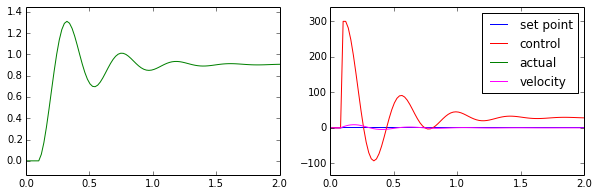

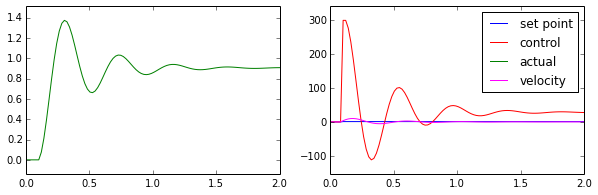

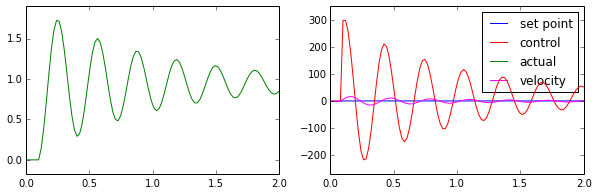

In [11]:
plot_behavior(xset=1, kp=300, ki=0, kd=0, m=1, b=10, k=20, g=300, s=1, total_time=2, npoints=100)
plot_behavior(xset=1, kp=300, ki=0, kd=0, m=1, b=10, k=20, g=1000, s=1, total_time=2, npoints=100)
plot_behavior(xset=1, kp=300, ki=0, kd=0, m=1, b=10, k=20, g=1000, s=2, total_time=2, npoints=100)

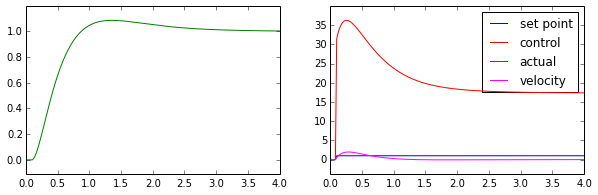

In [13]:
plot_behavior(xset=1, kp=30, ki=70, kd=0, m=1, b=10, k=20, g=30, s=3, total_time=4, npoints=200)

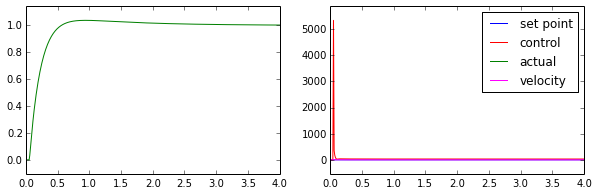

In [19]:
plot_behavior(xset=1, kp=350, ki=300, kd=50, m=1, b=10, k=20, g=350, s=1, total_time=4, npoints=400)

70.0 447.253333333 7.30383973289


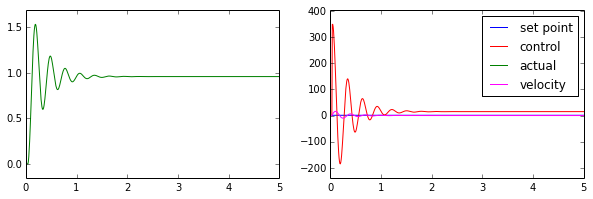

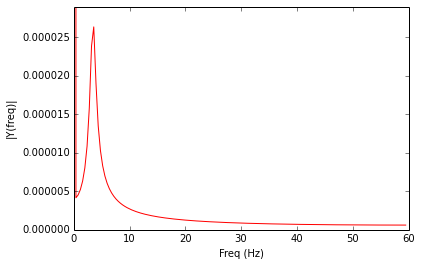

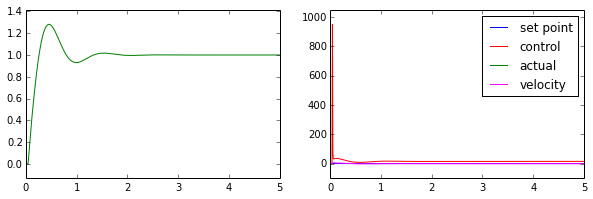

In [8]:
kp = 350
tt,xx0,aa,xx,vv = plot_behavior(xset=1, kp=kp, ki=0, kd=0, m=1, b=10, k=20, g=1000, s=2, total_time=5, npoints=600)

Fs = 1/(tt[1] - tt[0]) # sampling rate
n = len(xx[len(xx)//2:]) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range

Y = np.fft.fft(xx[len(xx)//2:])/n # fft computing and normalization
Y = Y[range(n//2)]

fig, ax = plt.subplots()
ax.plot(frq,abs(Y),'r') # plotting the spectrum
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('|Y(freq)|')
ax.set_ylim(0,1.1*max(abs(Y[2:])))

cont = Controller(set_point=1)
cont.ziegler_nichols(ku=kp,tu=1/frq[2:][np.argmax(Y[2:])],control_type='no_overshoot')

print(cont.kp,cont.ki,cont.kd)

_=plot_behavior(xset=1, kp=cont.kp, ki=cont.ki, kd=cont.kd, m=1, b=10, k=20, g=1000, s=2, total_time=5, npoints=600)


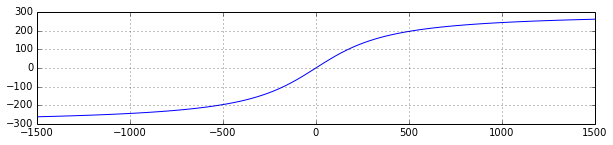

In [26]:
g,s = 300,1
x = np.linspace(-5*g,5*g,100)
fig,ax = pyplot.subplots(figsize=(10,10))
pt = ax.plot(x,g * (2/π) * np.arctan((s/g) * x))
ax.set_aspect('equal')
ax.grid(True)